**Picking points on image by clicking on them with the mouse**
PS: Doesn't work on colab

In [ ]:
from tkinter import *
from tkinter.filedialog import askopenfilename

event2canvas = lambda e, c: (c.canvasx(e.x), c.canvasy(e.y))

if __name__ == "__main__":
    root = Tk()

    #setting up a tkinter canvas with scrollbars
    frame = Frame(root, bd=2, relief=SUNKEN)
    frame.grid_rowconfigure(0, weight=1)
    frame.grid_columnconfigure(0, weight=1)
    xscroll = Scrollbar(frame, orient=HORIZONTAL)
    xscroll.grid(row=1, column=0, sticky=E+W)
    yscroll = Scrollbar(frame)
    yscroll.grid(row=0, column=1, sticky=N+S)
    canvas = Canvas(frame, bd=0, xscrollcommand=xscroll.set, yscrollcommand=yscroll.set)
    canvas.grid(row=0, column=0, sticky=N+S+E+W)
    xscroll.config(command=canvas.xview)
    yscroll.config(command=canvas.yview)
    frame.pack(fill=BOTH,expand=1)

    #adding the image
    File = askopenfilename(parent=root, initialdir="M:/",title='Choose an image.')
    print("opening %s" % File)
    img = PhotoImage(file=File)
    canvas.create_image(0,0,image=img,anchor="nw")
    canvas.config(scrollregion=canvas.bbox(ALL))

    #function to be called when mouse is clicked
    def printcoords(event):
        #outputting x and y coords to console
        
        print ("(%d, %d) " % (event.x,event.y))
    #mouseclick event
    canvas.bind("<ButtonPress-1>",printcoords)
    

    root.mainloop()
    
    

Image Stitching using points obtained

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import math

cores_right = np.array([[176, 176], [116, 179], [120, 208], [151, 202]])
cores_left = np.array([[187, 348], [124, 345], [126, 380], [160, 375]])

right_image size: (252, 378, 3)
left_image size: (252, 378, 3)


<Figure size 432x288 with 0 Axes>

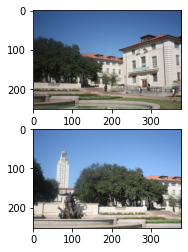

In [ ]:
PATH1 = "image1.jpeg"
PATH2 = "image2.jpeg"

left_bgr = cv2.imread(PATH1)
left_image = cv2.cvtColor(left_bgr, cv2.COLOR_BGR2RGB)
right_bgr = cv2.imread(PATH2)
right_image = cv2.cvtColor(right_bgr, cv2.COLOR_BGR2RGB)


plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(right_image)
axarr[1].imshow(left_image)

print("right_image size:",right_image.shape)
print("left_image size:",left_image.shape)

In [ ]:
def form_matrix_A(cores_right, cores_left):
  A = np.zeros((2*cores_right.shape[0],9))
  for point in range(0, cores_right.shape[0]):
    A[2*point] =   [-cores_right[point][0], -cores_right[point][1], -1, 0, 0, 0, cores_right[point][0]*cores_left[point][0], cores_right[point][1]*cores_left[point][0], cores_left[point][0]]
    A[2*point+1] = [0, 0, 0, -cores_right[point][0], -cores_right[point][1], -1, cores_right[point][0]*cores_left[point][1], cores_right[point][1]*cores_left[point][1], cores_left[point][1]]
  return A
  
def compute_homography_matrix(cores_right, cores_left):
  A = form_matrix_A(cores_right, cores_left)
  U, S, VT = np.linalg.svd(A)
  h=VT[-1]
  H = h.reshape((3, 3))
  H=H/h[-1]
  return H
  
def homog_to_hetrog(point):
    point = point / point[-1]
    return point[:-1]
  

In [ ]:
def compute_inverse_warp_coordinates(H, image):
  coordinates = np.zeros((image.shape[0], 2*image.shape[1],2))
  H_inv = np.linalg.inv(H)
  for r in range(0,coordinates.shape[0]):
    for c in range(0,coordinates.shape[1]):
      coordinates[r][c] = homog_to_hetrog(np.dot(H_inv, [r, c, 1]))
  return coordinates

def split_to_color_channels(image):
  red_channel = image[:,:,0]
  green_channel = image[:,:,1]
  blue_channel = image[:,:,2]
  return red_channel, green_channel, blue_channel

In [ ]:
def channel_linear_interpoltion(color_channel, image_coordinates, inverse_warp_coordinates):
  interpolated_intensity = griddata(image_coordinates, color_channel.reshape((color_channel.size)), inverse_warp_coordinates, method='linear')
  return interpolated_intensity

In [ ]:
def compute_warped_channels(image, H):
  frame_red = np.zeros((image.shape[0], 2*image.shape[1]))
  frame_green = np.zeros((image.shape[0], 2*image.shape[1]))
  frame_blue = np.zeros((image.shape[0], 2*image.shape[1]))
  red_channel, green_channel, blue_channel = split_to_color_channels(image)
  #creates all possible image coordinates (used in griddata)
  coordinates = np.array([(x,y) for x in range(red_channel.shape[0]) for y in range(red_channel.shape[1])], dtype=np.double)
  inverse_warp_coordinates = compute_inverse_warp_coordinates(H,image)

  frame_red = channel_linear_interpoltion(red_channel, coordinates, inverse_warp_coordinates)
  frame_green = channel_linear_interpoltion(green_channel, coordinates, inverse_warp_coordinates)
  frame_blue = channel_linear_interpoltion(blue_channel, coordinates, inverse_warp_coordinates)

  return frame_red, frame_green, frame_blue

In [ ]:
def mosiac(right_image, left_image, cores_right, cores_left):
  H = compute_homography_matrix(cores_right, cores_left)
  H_inv = np.linalg.inv(H)
  frame_red, frame_green, frame_blue = compute_warped_channels(right_image, H)
  red_channel_left, green_channel_left, blue_channel_left = split_to_color_channels(left_image)
  #overlay both images for each channel
  frame_red[0:0+red_channel_left.shape[0], 0:0+red_channel_left.shape[1]] = red_channel_left
  frame_green[0:0+green_channel_left.shape[0], 0:0+green_channel_left.shape[1]] = green_channel_left
  frame_blue[0:0+blue_channel_left.shape[0], 0:0+blue_channel_left.shape[1]] = blue_channel_left
  #merge all colour channels
  panorama = (np.dstack((frame_red, frame_green, frame_blue))) .astype(np.uint8)
  plt.imshow(panorama)


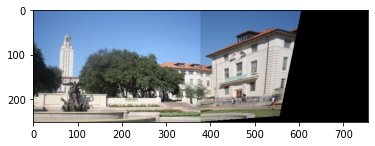

In [ ]:
mosiac(right_image,left_image,cores_right, cores_left)